In [208]:
import numpy as np
import pandas as pd
import math

import tensorflow as tf
import tensorflow_datasets as tfds

from scipy.io import loadmat
from scipy.stats import chisquare
import scipy.cluster.hierarchy as hc

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.inspection import DecisionBoundaryDisplay

import matplotlib.pyplot as plt

# 1. Support Vector Machines

[Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine), or SVM in short, is a supervised binary classification algorithms suitable for numerical data.


## 1.1 Theory

The main idea behind SVM is that our labeled data might be embedded in a vector space such that each cluster with different labels are separable via a hyperplane.  [Here](http://fourier.eng.hmc.edu/e161/lectures/svm/node1.html) is another good mathematical explanation of how and why SVM works.

In this setup, the data we have is a set of pairs $(x^{(i)},y^{(i)})$ where $x^{(i)}\in\mathbb{R}^n$ and $y^{(i)}=
\pm 1$ for every index $i=1,\ldots,N$.

Below, I will sample a random collection of points from $\mathbb{R}^2$ separable by many different hyperplanes.

Our dataset $\{x^{(i)}\}$ consists of points in a vector space $\mathbb{R}^n$, in other words each data point $x^{(i)}$ has $n$-components.  We also have a binary labelling scheme: each data point is labelled by one of two labels. For convenience, we choose these labels to be $+1$ and $-1$.

![img](images/svm.png)

In the simplest version of the setup, the data is linearly separable, i.e. there is a hyperplane that sits in between class of points labelled as +1, and class of points labelled as -1.  Our aim is to find such a hyperplane with *the largest margin.*  The margin is the width of the gap on both sides of the hyperplane that fits between the datasets of different labels.

## 1.2 Some linear algebra

Recall from linear algebra that each hyperplane is determined by a normal vector $\mathbf{w}$ and a displacement $b$ from the origin.  Then the set of points on the hyperplane determined by $\mathbf{w}$ and displacement $b$ is given by

$$ \mathbf{w}\cdot\mathbf{x} + b = 0 $$

And this hyperplane splits our space into two disjoint subspaces: one subspace on one side of the hyperplane, while the other lies on the other side of the hyperplane.  More importantly for us, each side is determined by the sign of the displaced inner product.

$$ H_+ = \{ \mathbf{x}\in\mathbb{R}^n\mid \mathbf{w}\cdot\mathbf{x} + b > 0 \} $$
and
$$ H_- = \{ \mathbf{x}\in\mathbb{R}^n\mid \mathbf{w}\cdot\mathbf{x} + b < 0 \} $$


## 1.3 The optimization problem

From the argument above, we see that $\mathbf{w}$ and $b$ need to satisfy the following constraint on our dataset:

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) > 0 $$

Notice that $\mathbf{w}$ and $b$ do satisfy the constraint above then for every $\lambda>0$ we also have

$$ y^{(i)}(\lambda\mathbf{w}\cdot\mathbf{x}^{(i)}+\lambda b) > 0 $$

So, we choose a *normalization* for the pair of parameters $\mathbf{w}$ and $b$ and set

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $$


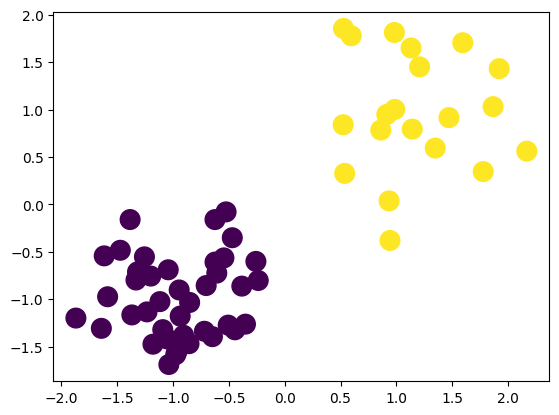

In [243]:
def randDisk(center,r,N):
    result = []
    x0,y0=center
    for i in range(N):
        r0 = np.random.normal(loc=r,scale=r/2)
        theta = np.random.uniform(0, 2*math.pi)
        result.append([x0+r0*math.cos(theta),y0+r0*math.sin(theta)])
    return result

tmp = randDisk([1,1],0.6,20)
tmp.extend(randDisk([-1,-1],0.5,40))

X = np.array(tmp)
v = [1,1]
y = [1 if np.dot(x,v)>0 else -1 for x in X]

plt.scatter(X[:,0],X[:,1],s=200,c=y)

Now, look at the picture above. We need a separating hyperplane given by a pair $(w,b)$ where $w\in\mathbb{R}^n$ and $b\in \mathbb{R}$ such that

$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $ for every $i=1,\ldots,N$

If this condition is satisfied then the gap between the separating hyperplanes becomes $\frac{2}{\|w\|}$. Thus maximizing the gap becomes equivalent to finding a suitable vector $w$ with the smallest norm.

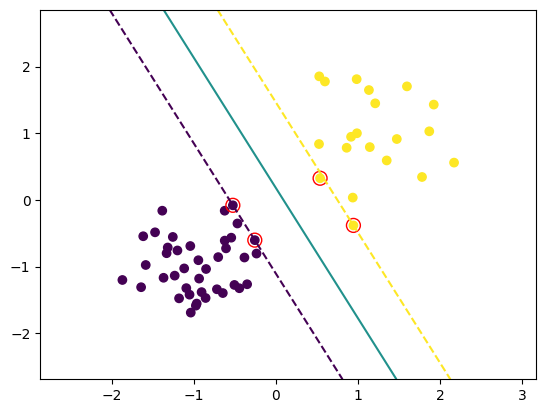

In [248]:
model = SVC(kernel="linear",C=1.0)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red",
)

## 1.2 Hard Margin vs Soft Margin

The standard SVM model operates on the assumption that the data is separable. This situation is described by having a **hard margin**.

In cases where the data is not completely separable, we might allow some mixing within the margin. In these cases, we use a **soft margin** and we would like to allow some points being inside the margin. We call this situation as SVM classifier with *a soft margin*.  In mathematical terms, we do not strictly insist on the condition

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $$

and allow points transgress the boundary with some error

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1-\xi_i $$

But this time we optimize

$$ \|\mathbf{w}\| + C \sum_{i=1}^N \xi_i^2 $$

where $C$ is a hyper-parameter we tune for the application at hand.

Please read [these lecture notes](http://fourier.eng.hmc.edu/e161/lectures/svm/node5.html) and [sklearn SVM with soft margins](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html) from the [sklearn documentation](https://scikit-learn.org/stable/user_guide.html).

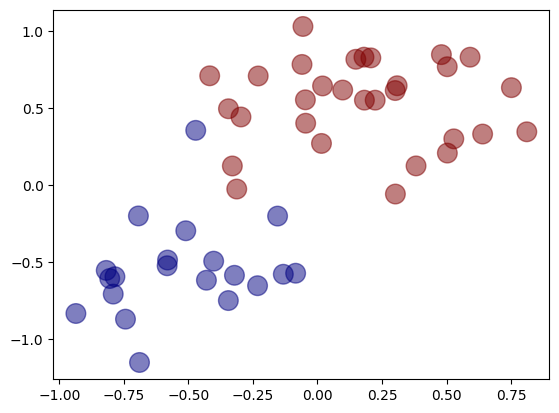

In [266]:
N1 = 30
N2 = 20

y = list([1]*N1 + [0]*N2)

new = randDisk([0.2,0.5],0.4,N1)
new.extend(randDisk([-0.5,-0.5],0.4,N2))
X = np.array(new)

plt.scatter(X[:,0],X[:,1],c=cnew,cmap='jet',s=200,alpha=0.5)

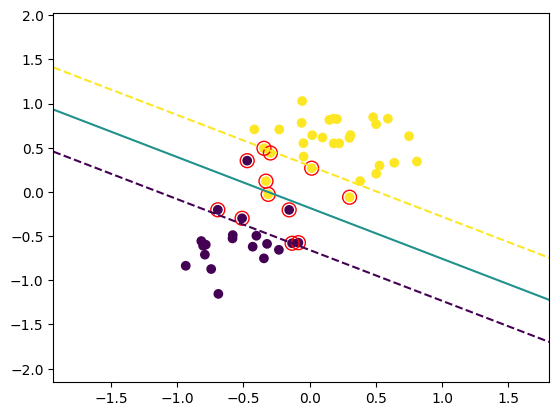

In [267]:
model = SVC(kernel="linear",C=1.0)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red",
)

## 1.3 The Kernel Trick

There is another parameter that we can play with. That is the inner product we work with. 

Recall that our method heavily relies on the inner product since we either minimize $\|w\|$ subject to 

$y^{(i)}(x^{(i)}\cdot w - b) \geq 0 $

or minimizing the total hinge loss function

$\lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b))$

We can also use different inner products other than the ordinary Euclidean one:

$x\cdot y = \sum_i x_i y_i$

This method is equivalent to embedding $\mathbb{R}^n$ into another larger $\mathbb{R}^m$ via a (non)linear embedding and then using the ambient Euclidean product in $\mathbb{R}^m$.  This is useful when the original dataset is not linearly separable.

There are three main classes of kernels you can use

* linear
* polynomial
* radial basis function (RBF)

You can read the documentation [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html).

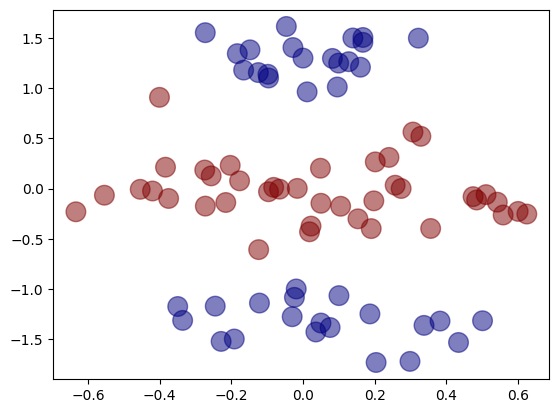

In [290]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.4],0.3,20))

X = np.array(tmp)
y = [1]*40 + [-1]*40

plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',s=200,alpha=0.5)

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="rbf",C=1.0,degree=2)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9642857142857143

## 1.4 Multiclass SVM

Above we worked with SVM with binary classification. However, SVM is versatile enough to work with multiclass classification problems.

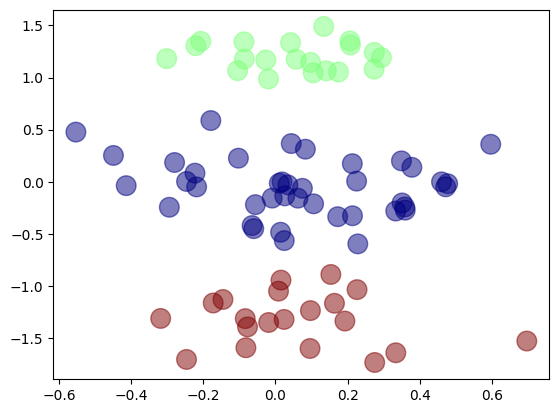

In [292]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.3],0.3,20))

X = np.array(tmp)
y = [1]*40 + [2]*20 + [3]*20

plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',s=200,alpha=0.5)

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="linear",C=1.0,degree=2)
model.fit(X_train,y_train)
model.score(X_test,y_test)

1.0

## One large example (MNIST)

[MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits stored as grayscale images of size 28x28 pixels.

![MNIST sample](./images/MNIST-sample.png)


In [109]:
data, info = tfds.load('mnist', split=None, data_dir='/home/kaygun/local/data/tensorflow_datasets/', with_info=True, shuffle_files=True)

In [110]:
data

{'test': <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'train': <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [111]:
def tfGetData(df,N):
    X_train = []
    y_train = []
    tmp = df.take(N).cache().as_numpy_iterator()
    for u in tmp:
        X_train.append(u['image'].reshape((28*28)))
        y_train.append(u['label'])
    return X_train,y_train

In [112]:
X_train,y_train = tfGetData(data['train'],2000)
X_test,y_test = tfGetData(data['test'],1000)

model = SVC(kernel='rbf',C=2.0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
confusion_matrix(y_test,y_pred)

2022-11-14 11:38:19.088777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-14 11:38:19.253454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[107,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0, 122,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0, 103,   1,   1,   0,   1,   4,   1,   0],
       [  0,   0,   3,  82,   0,   0,   0,   1,   0,   1],
       [  0,   0,   0,   0,  85,   0,   0,   0,   0,   0],
       [  1,   0,   1,   5,   1,  79,   0,   0,   1,   1],
       [  0,   1,   1,   0,   1,   3,  97,   0,   0,   0],
       [  0,   1,   3,   1,   0,   0,   0,  99,   0,   1],
       [  0,   0,   2,   0,   0,   1,   2,   1,  92,   1],
       [  2,   0,   0,   0,   2,   2,   0,   0,   0,  83]])

In [113]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       108
           1       0.98      1.00      0.99       122
           2       0.91      0.91      0.91       113
           3       0.92      0.94      0.93        87
           4       0.94      1.00      0.97        85
           5       0.93      0.89      0.91        89
           6       0.96      0.94      0.95       103
           7       0.94      0.94      0.94       105
           8       0.98      0.93      0.95        99
           9       0.95      0.93      0.94        89

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



## Another Example

In [293]:
pine = loadmat('./data/Indian_pines.mat')['indian_pines']
pine_gt = loadmat('./data/Indian_pines_gt.mat')['indian_pines_gt']

X = pine.reshape((145*145,220))
y = pine_gt.reshape(145*145)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.3)

In [294]:
model = SVC(kernel='rbf',C=2.0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[6898,    0,   95,    0,    0,    0,    0,    0,   75,    0,    0,
         446,    0,    0,    0,    0,   22],
       [   7,    0,    0,    0,    0,    0,    0,    0,   19,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 192,    0,  325,    0,    0,    0,    0,    0,    0,    0,    0,
         478,    0,    0,    0,    0,    0],
       [ 185,    0,   71,    0,    0,    0,    0,    0,    0,    0,    0,
         296,    0,    0,    0,    0,    0],
       [  95,    0,   69,    0,    0,    0,    0,    0,    0,    0,    0,
           8,    0,    0,    0,    0,    0],
       [ 330,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 533,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  22,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  77,    0,    0,    0,    0,    0,    0

In [295]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.92      0.78      7536
           1       0.00      0.00      0.00        26
           2       0.47      0.33      0.39       995
           3       0.00      0.00      0.00       552
           4       0.00      0.00      0.00       172
           5       0.00      0.00      0.00       330
           6       0.00      0.00      0.00       533
           7       0.00      0.00      0.00        22
           8       0.73      0.77      0.75       331
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00       698
          11       0.42      0.84      0.56      1718
          12       0.00      0.00      0.00       416
          13       0.00      0.00      0.00       155
          14       0.00      0.00      0.00       889
          15       0.00      0.00      0.00       267
          16       0.70      0.78      0.74        65

    accuracy              

/home/kaygun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaygun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 2. REVIEW

In the last lecture we looked at logistic regression and SVM. The algorithm is one specific example of what we call *binary classification/clustering problems*.

## Examples of classification/clustering algorithms

1. [k-means](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html): This is a clustering algorithm since it is unsupervised. We can set $k=2$ as well as $k>2$.

2. [k-nn](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4916348/): This is a classification algorithm since it is supervised. Again $k$ could be 2 or more.

3. [Logistic regression](https://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/lecturenote06.html): This is again a classification algorithm. This time we can only split into 2 classes.

4. [SVM](https://nlp.stanford.edu/IR-book/html/htmledition/support-vector-machines-and-machine-learning-on-documents-1.html): This is also a classification algorithm. It also works in cases where one has more than 2 classes.


# 3. Hiearchical clustering

The [hiearchical clustering](https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/hierarchical.html) is an unsupervised partitioning (i.e. a clustering) problem.  Here is the setup: Hierarchical clustering algorithm is an unsupervised algorithm. The algorithm gradually merge points into clusters. 

1. Place each point in a cluster that contain only themselves.
2. Merge two clusters with the smallest distance.
3. Repeat Step 2 until all clusters are merged.

The algorithm works by placing a ball $B_\epsilon(x)$ of radius $\epsilon$ on each $x\in D$. We merge two points $x_1$ and $x_2$ at a specific $\epsilon$ if $B_\epsilon(x_1)$ and $B_\epsilon(x_2)$ intersect. While this is straightforward for individual pairs of points, one has to decide how clusters of points merge when $\epsilon$ is large enough. This is called the *linkage* method. 

Let us use $ d_{(ij)k} $ to denote the distance between the clusters $ C_{k} $ and $ C_{ij} = C_i \cup C_j $ which is merged in a single cluster.  One calculates the distance 
\\[ d_{(ij)k} = \alpha_{ijk} d_{ik} +\alpha_{jik} d_{jk}+ \beta_{ijk} d_{ij} + \gamma|d_{ik}-d_{jk}| \\] 
for parameters $\alpha_{ijk}$, $\beta_{ijk}$ and $\gamma$ to be determined.  

The most frequently used linkage methods are 

1. Single
2. Complete
3. Average
4. Ward

The parameters for commonly used methods of calculating distances between clusters.

<table>
    <tr><th style="width:100px">Linkage</th>
        <th style="width:100px">$\alpha_{ijk}$</th>
        <th style="width:100px">$\beta_{ijk}$</th>
        <th style="width:100px">$\gamma$</th></tr>
    <tr><td>Single</td>
        <td>$\frac{1}{2}$</td>
        <td>0</td>
        <td>$-\frac{1}{2}$</td></tr>
    <tr><td>Complete</td>
        <td>$\frac{1}{2}$</td>
        <td>0</td>
        <td>$\frac{1}{2}$</td></tr>
    <tr><td>Average</td>
        <td>$\frac{n_i}{n_i+n_j}$</td>
        <td>0</td>
        <td>0</td></tr>
    <tr><td>Ward</td>
        <td>$\frac{n_i+n_k}{n_i+n_j+n_k}$</td>
        <td>$\frac{-n_k}{n_i+n_j+n_k}$</td>
        <td>0</td></tr>
</table>

In [ ]:
raw = datasets.load_iris()
X = raw['data']
y = raw['target']

In [ ]:
model = AgglomerativeClustering(n_clusters=3)
model.fit(X)
y_pred = model.fit_predict(X)
confusion_matrix(y,y_pred)

In [157]:
chisquare(confusion_matrix(y_test,y_pred),axis=None)

Power_divergenceResult(statistic=62.89473684210527, pvalue=1.2566944903065467e-10)

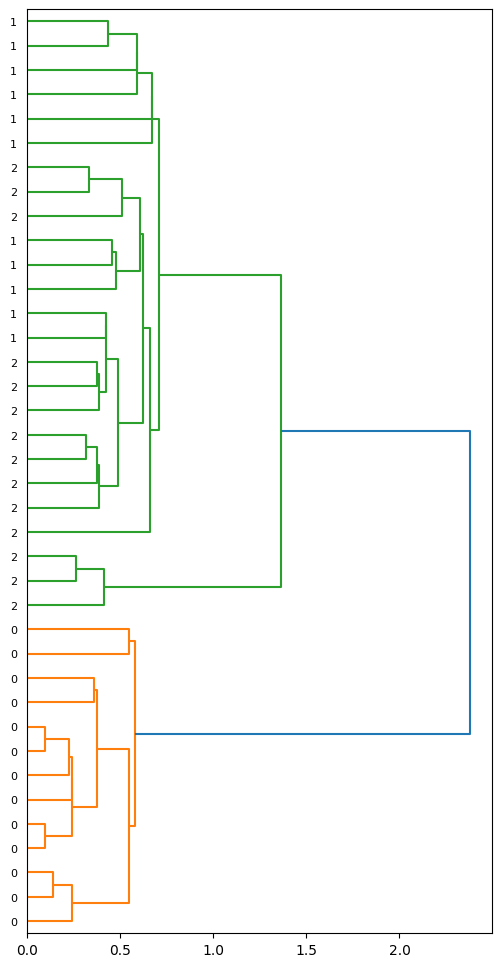

In [158]:
plt.figure(figsize=(6,12))
den = hc.dendrogram(hc.linkage(X_test, method='single'), orientation='right',labels=y_test)

In [228]:
arrests = pd.read_csv('./data/USArrests.csv')
arrests

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


In [231]:
X = arrests[['Murder','Assault','Rape']]
y = arrests['Unnamed: 0']

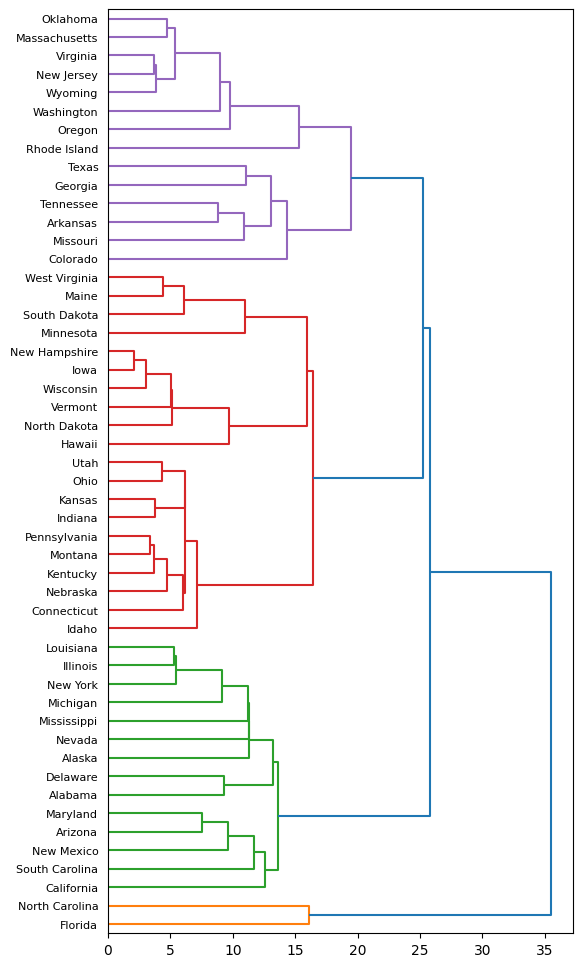

In [239]:
plt.figure(figsize=(6,12))
den = hc.dendrogram(hc.linkage(X.to_numpy(), method='single'), orientation='right',labels=y.to_numpy())

# 4. DB-Scan

DB-Scan is a unsupervised algorithm. So, we only have data points $x^{(1)},\ldots,x^{(N)}$ and no output labels. The parameters are 

1. A real number $\epsilon>0$, and 
2. A natural number $N$

The key concepts for this algorithm are

1. Core point
2. Density connected points
3. Density reachable points
   1. Direct
   2. Indirect
4. Border points
5. Outliers

### Core points

A point $x\in D$ is called a *core point* if $B_\epsilon(x)$ the ball with radius $\epsilon$ centered at $x$ contains $N$ points from $D$.

### Density connected points

A pair of points $x$ and $y$ are called *density connected* if there is a core point $w$ such that $x,y\in B_\epsilon(w)$.

### Density reachable points

A point $x\in D$ is called a *directly density reachable* if $x$ is lies inside $B_\epsilon(u)$ the disk of radius $\epsilon$ centered at a core point $u$. 

We call a point *indirectly density reachable* if there is a link of density connected points $x^{(1)},\ldots,x^{(p)}$ i.e. $d(x^{(i)},x^{(i+1)})<\epsilon$ for $i=1,\ldots,p-1$ and $d(x^{(p)},x)<\epsilon$.

### Border points

A point $x$ is called a *border point* if it is a density reachable point but $B_\epsilon(x)$ has less than $N$ points from $D$.

### Outlier points

A point $x$ is called an outlier if $B_\epsilon(x)$ contains less than $N$ points and $x$ is not a density reachable point.

### The Algorithm

We put point a collection of points $x^{(1)},\ldots,x^{(\ell)}$ in the same cluster if they are density reachable from each other.


In [159]:
model = DBSCAN()
model.fit(X)
predicted = model.fit_predict(X)
confusion_matrix(y,predicted)

array([[ 0,  0,  0,  0],
       [ 1, 49,  0,  0],
       [ 6,  0, 44,  0],
       [10,  0, 40,  0]])

In [167]:
chisquare(confusion_matrix(y,predicted),axis=None)

Power_divergenceResult(statistic=1967321.854696789, pvalue=0.0)

In [168]:
pine = loadmat('./data/Indian_pines.mat')['indian_pines']
pine_gt = loadmat('./data/Indian_pines_gt.mat')['indian_pines_gt']

X = pine.reshape((145*145,220))
y = pine_gt.reshape(145*145)

In [169]:
model = DBSCAN()
model.fit(X)
predicted = model.fit_predict(X)

In [170]:
chisquare(confusion_matrix(y,predicted))

/home/kaygun/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:6766: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


Power_divergenceResult(statistic=array([89438.71414982,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan]), pvalue=array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan]))